Projek Akhir Mata Kuliah Machine Learning Kelas E

Kelompok 8:

1.Salsabila Oktafani_2010511001

2.Alvin Putra Perdana_2010511011

3.Jihan Kamilah_2010511013

4.Nurhikmah Mawaddah Solin_2010511026

# Import Library

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from numpy import expand_dims

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50

import skimage
from skimage import color

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Link Dataset: https://drive.google.com/drive/folders/1c_APRJ26tW_F3Kqyuc1ZdkzCNZDDU25D?usp=sharing

# Check Dataset

In [ ]:
path = '../content/drive/My Drive/Last Project/Grapevine_Dataset/'
path_Ak = path + 'Ak'
path_Ala_Idris = path + 'Ala_Idris'
path_Buzgulu = path + 'Buzgulu'
path_Dimnit = path + 'Dimnit'
path_Nazli = path + 'Nazli'

In [ ]:
main_df = pd.DataFrame()

In [ ]:
main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

In [ ]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(path+class_+'/'+image)

main_df['classes'] = classes
main_df['path'] = paths

main_df.head

<bound method NDFrame.head of              images classes                                               path
0       Ak (14).png      Ak  ../content/drive/My Drive/Last Project/Grapevi...
1        Ak (1).png      Ak  ../content/drive/My Drive/Last Project/Grapevi...
2       Ak (13).png      Ak  ../content/drive/My Drive/Last Project/Grapevi...
3       Ak (11).png      Ak  ../content/drive/My Drive/Last Project/Grapevi...
4       Ak (12).png      Ak  ../content/drive/My Drive/Last Project/Grapevi...
..              ...     ...                                                ...
495  Nazli (99).png   Nazli  ../content/drive/My Drive/Last Project/Grapevi...
496  Nazli (96).png   Nazli  ../content/drive/My Drive/Last Project/Grapevi...
497  Nazli (98).png   Nazli  ../content/drive/My Drive/Last Project/Grapevi...
498  Nazli (94).png   Nazli  ../content/drive/My Drive/Last Project/Grapevi...
499  Nazli (92).png   Nazli  ../content/drive/My Drive/Last Project/Grapevi...

[500 rows x 3 columns

In [ ]:
main_df.isna().sum()

images     0
classes    0
path       0
dtype: int64

In [ ]:
print('Leaves Count: ',len(main_df['classes'].value_counts()))
main_df['classes'].value_counts()

Leaves Count:  5


Ak           100
Ala_Idris    100
Buzgulu      100
Dimnit       100
Nazli        100
Name: classes, dtype: int64

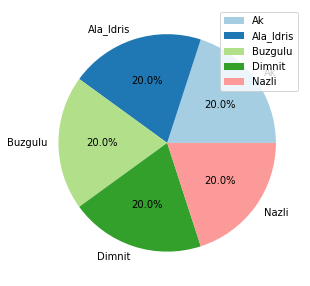

In [ ]:
plt.figure(figsize=(5,5))
class_cnt = main_df.groupby(['classes']).size().reset_index(name = 'counts')
colors = sns.color_palette('Paired')[0:9]
plt.pie(class_cnt['counts'], labels=class_cnt['classes'], colors=colors, autopct='%1.1f%%')
plt.legend(loc='upper right')
plt.show()

# Augmentasi

In [ ]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224)) #resize citra
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10, 5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
  
    plt.show()

# Splitting Data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(main_df[['path', 'classes']], main_df[['classes']], test_size=0.2, random_state=42)

# RESNET50

In [ ]:
#mengubah citra input dari RGB ke BGR
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 400 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


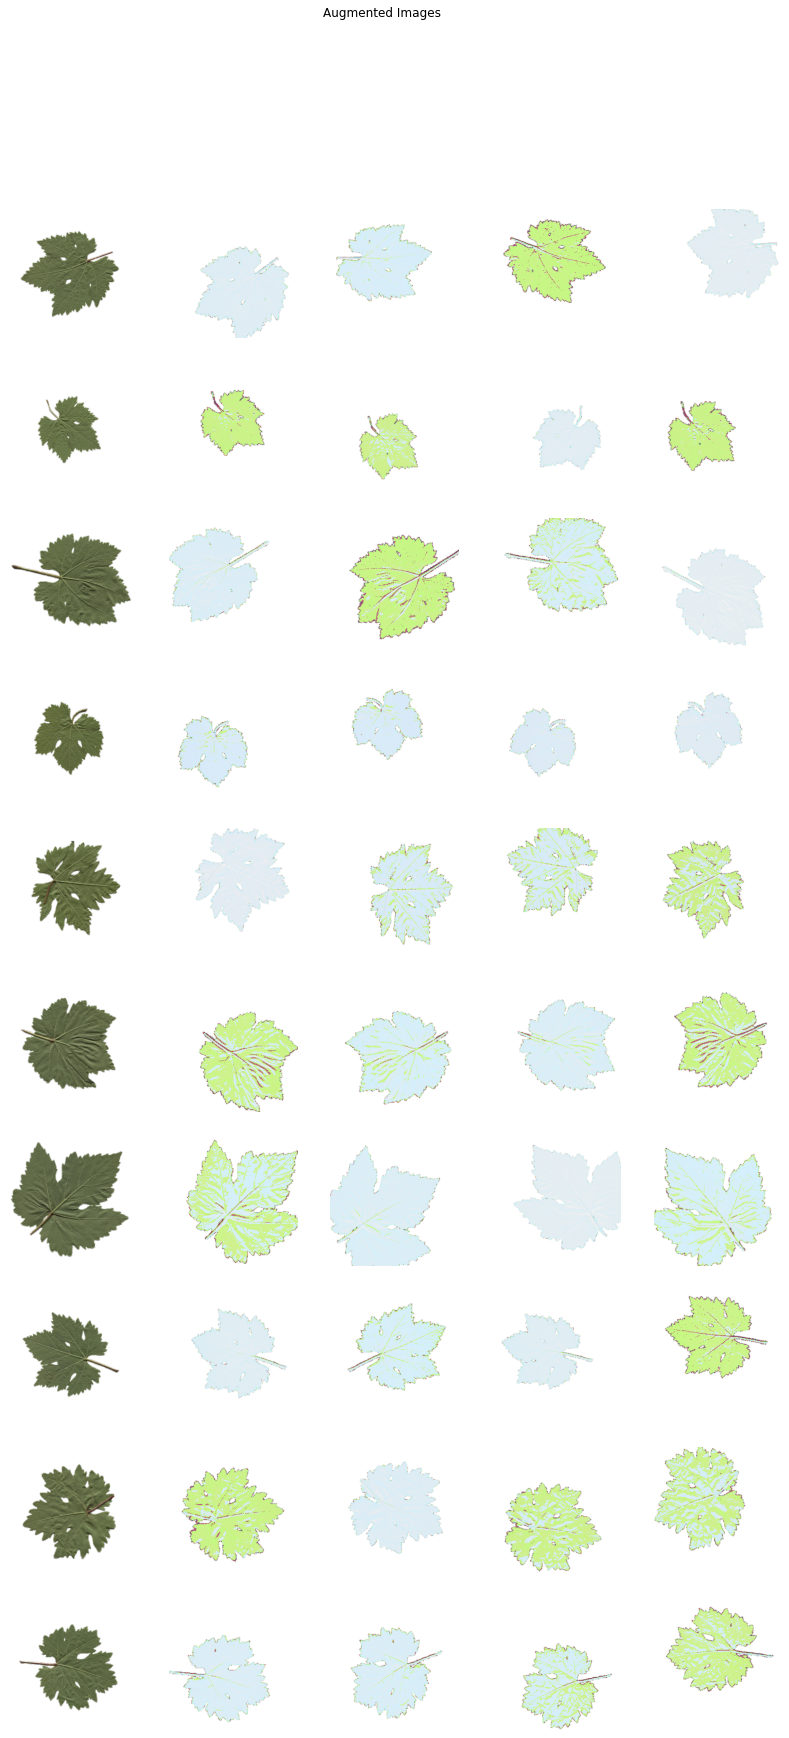

In [ ]:
plot_augimages(np.random.choice(main_df['path'],10), resnet50_datagen)

In [ ]:
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(5, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=50,
      verbose=2)

Epoch 1/50
13/13 - 225s - loss: 1.6444 - accuracy: 0.2925 - precision_1: 0.2273 - recall: 0.0250 - val_loss: 1.5268 - val_accuracy: 0.3900 - val_precision_1: 1.0000 - val_recall: 0.0200 - 225s/epoch - 17s/step
Epoch 2/50
13/13 - 85s - loss: 1.4010 - accuracy: 0.3900 - precision_1: 0.7000 - recall: 0.0700 - val_loss: 1.3181 - val_accuracy: 0.4600 - val_precision_1: 0.6316 - val_recall: 0.1200 - 85s/epoch - 7s/step
Epoch 3/50
13/13 - 86s - loss: 1.2191 - accuracy: 0.5400 - precision_1: 0.7500 - recall: 0.1275 - val_loss: 1.2123 - val_accuracy: 0.5500 - val_precision_1: 0.9231 - val_recall: 0.1200 - 86s/epoch - 7s/step
Epoch 4/50
13/13 - 84s - loss: 1.0920 - accuracy: 0.6600 - precision_1: 0.8500 - recall: 0.2125 - val_loss: 1.0688 - val_accuracy: 0.5700 - val_precision_1: 0.8571 - val_recall: 0.3000 - 84s/epoch - 6s/step
Epoch 5/50
13/13 - 84s - loss: 0.9774 - accuracy: 0.6850 - precision_1: 0.9122 - recall: 0.3375 - val_loss: 1.0519 - val_accuracy: 0.6800 - val_precision_1: 0.8529 - val

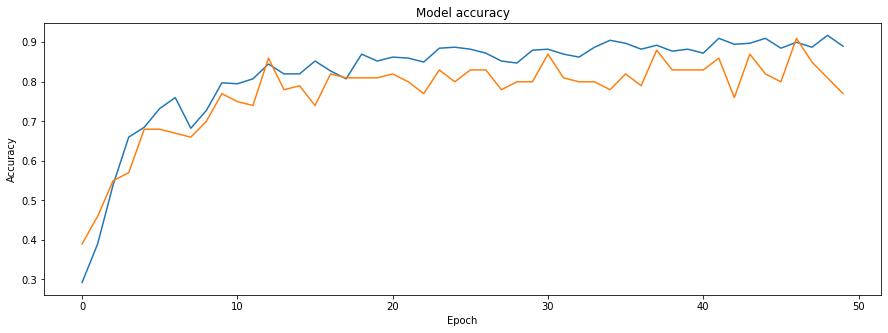

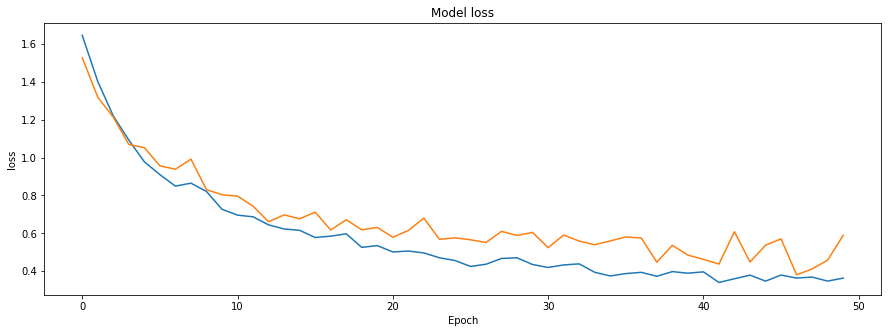

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model_resnet50.save('./model_resnet50.h5')

In [ ]:
from keras.models import load_model
model = load_model('./model_resnet50.h5')

In [ ]:
print("Loss of the model is - " , model.evaluate(val_generator_resnet50)[0])
print("Accuracy of the model is - " , model.evaluate(val_generator_resnet50)[1]*100 , "%")

4/4 [==============================] - 17s 4s/step - loss: 0.5164 - accuracy: 0.8000 - precision_1: 0.9024 - recall: 0.7400
Loss of the model is -  0.5164044499397278
4/4 [==============================] - 18s 4s/step - loss: 0.5076 - accuracy: 0.8500 - precision_1: 0.8929 - recall: 0.7500
Accuracy of the model is -  85.00000238418579 %


# VGG19

In [ ]:
from keras.applications.vgg19 import preprocess_input

In [ ]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 400 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


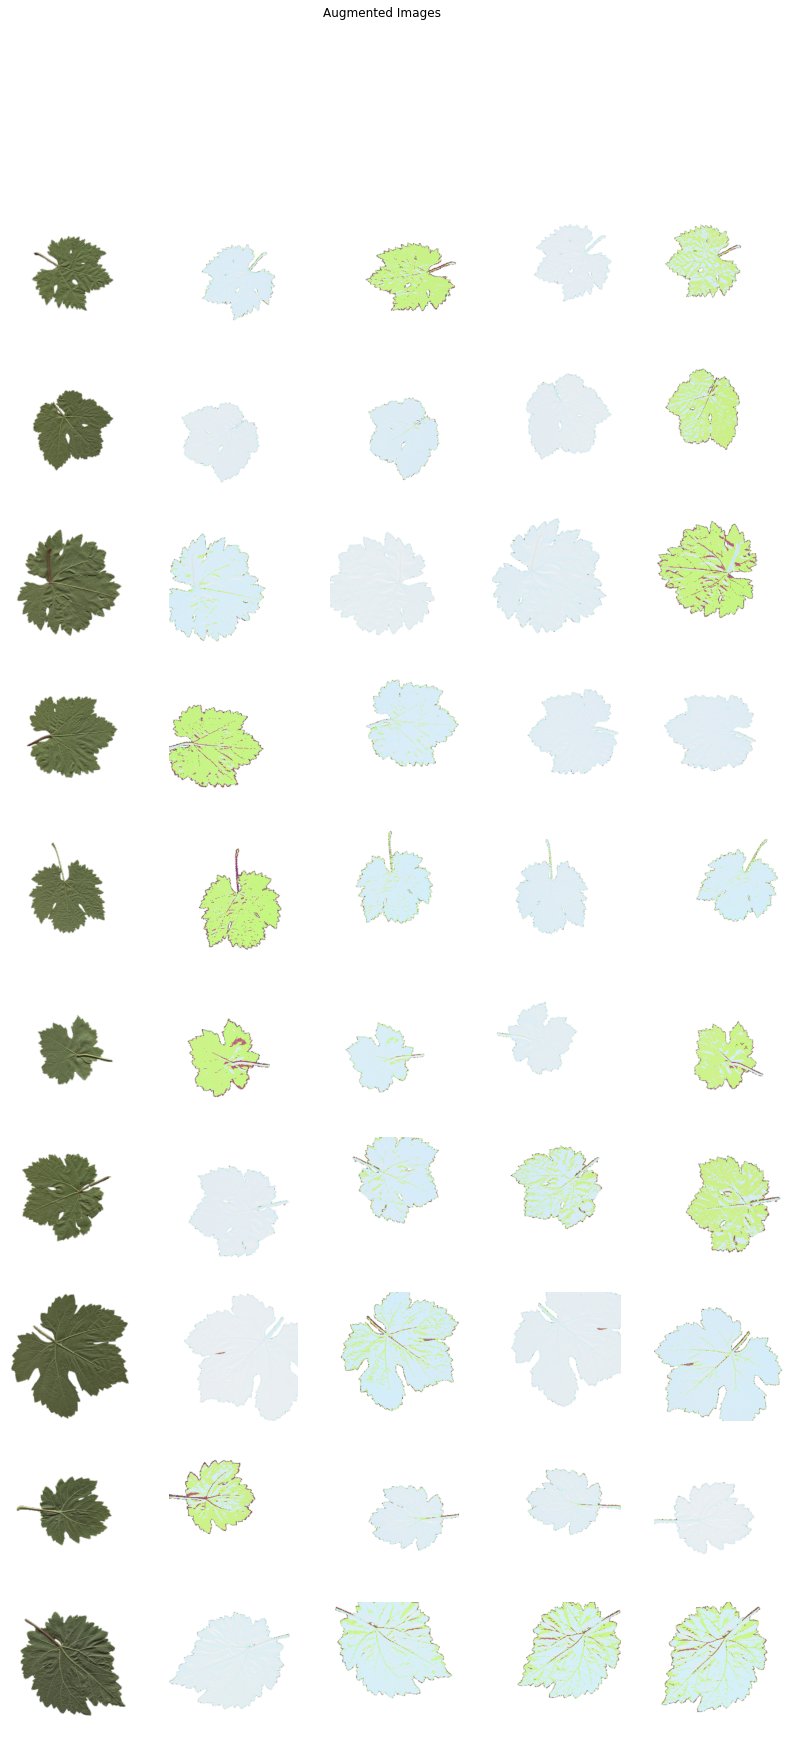

In [ ]:
plot_augimages(np.random.choice(main_df['path'],10), vgg_datagen)

In [ ]:
vgg19 = VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg19.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_vgg = model_vgg.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=50,
      verbose=2)

Epoch 1/50
13/13 - 353s - loss: 2.0781 - accuracy: 0.2500 - precision: 0.2908 - recall: 0.1425 - val_loss: 2.0274 - val_accuracy: 0.1500 - val_precision: 0.1875 - val_recall: 0.0900 - 353s/epoch - 27s/step
Epoch 2/50
13/13 - 337s - loss: 1.7269 - accuracy: 0.2950 - precision: 0.3380 - recall: 0.1200 - val_loss: 1.5402 - val_accuracy: 0.4300 - val_precision: 0.5152 - val_recall: 0.1700 - 337s/epoch - 26s/step
Epoch 3/50
13/13 - 337s - loss: 1.4807 - accuracy: 0.3850 - precision: 0.4634 - recall: 0.1900 - val_loss: 1.4519 - val_accuracy: 0.4800 - val_precision: 0.5455 - val_recall: 0.2400 - 337s/epoch - 26s/step
Epoch 4/50
13/13 - 340s - loss: 1.3068 - accuracy: 0.4575 - precision: 0.6095 - recall: 0.2575 - val_loss: 1.2739 - val_accuracy: 0.4700 - val_precision: 0.6667 - val_recall: 0.2600 - 340s/epoch - 26s/step
Epoch 5/50
13/13 - 334s - loss: 1.1919 - accuracy: 0.5300 - precision: 0.6772 - recall: 0.3200 - val_loss: 1.1916 - val_accuracy: 0.5400 - val_precision: 0.6591 - val_recall: 0

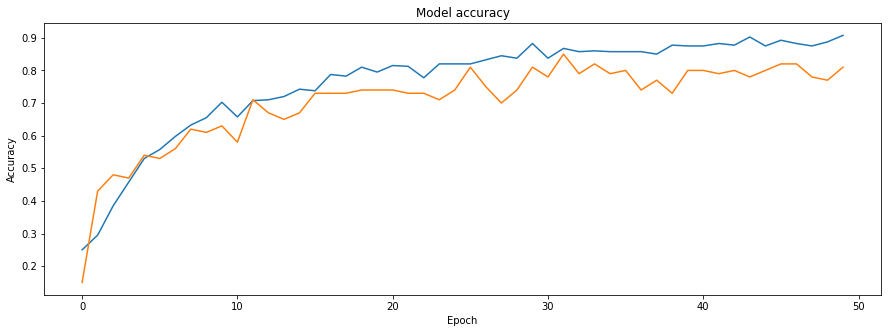

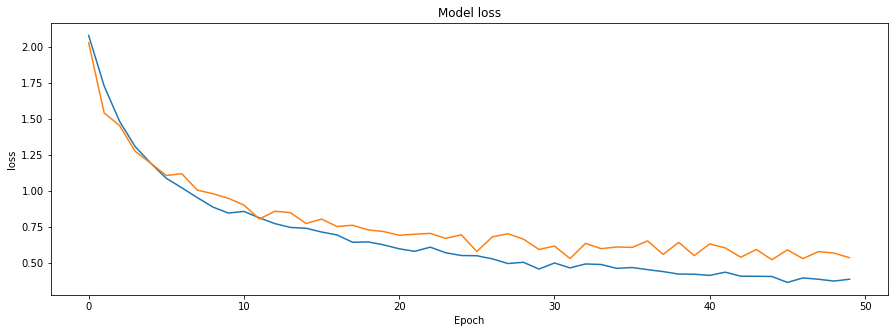

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model_vgg.save('./history_vgg.h5')

In [ ]:
from keras.models import load_model
model = load_model('./history_vgg.h5')

In [ ]:
print("Loss of the model is - " , model.evaluate(val_generator_vgg)[0])
print("Accuracy of the model is - " , model.evaluate(val_generator_vgg)[1]*100 , "%")

4/4 [==============================] - 65s 14s/step - loss: 0.4974 - accuracy: 0.8300 - precision: 0.8736 - recall: 0.7600
Loss of the model is -  0.49737653136253357
4/4 [==============================] - 65s 14s/step - loss: 0.5597 - accuracy: 0.8000 - precision: 0.8295 - recall: 0.7300
Accuracy of the model is -  80.0000011920929 %
